In [122]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

pd.options.display.max_rows = 500
#pd.options.display.max_columns = 4000

import sys
sys.path.append('../src/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
marco_geo_path = Path('../data/19_nuevoleon.gpkg')

In [298]:
# 19l Polígono de localidades urbanas y rurales amanzanadas
# 19a Áreas geoestadísticas básicas urbanas
# 19m Polígonos de manzana
mg_manzanas = gpd.read_file(marco_geo_path, layer='19m')#.query('CVE_MUN=="005"').plot(color='none')
mg_mun = gpd.read_file(marco_geo_path, layer='19mun')
mg_loc = gpd.read_file(marco_geo_path, layer='19l')
mg_agebs = gpd.read_file(marco_geo_path, layer='19a')

In [262]:
len(mg_loc)

1056

In [242]:
drop_cols = [
    'H-P', 'H-P-V', 'FechaHoraEnc', 'NumVisita', 'TipoEnc', 'RealizoEnc', 'Encuestador', 'Supervisor', 'RefDom',
    'Cod_EdoDomicilio', 'Obs_ENCUESTA', 'Obs_Encuestador', 'TodosEstan', 'Discapacidad_O', 'Estudios_O',
    'ViajeAyer', 'motivos', 'genero', 'estudios', 'disc', 'origen', 'Tiempo', 'tiempo_s', 'tiempo_m', 'tiempo_h',
    
]

rename_map = {
    'Cod_MunDomicilio': 'MUN', 'FE': 'FACTOR', 'Punto_zona': 'TAZ'
}

adress_cols = ['ColDom', 'CalleDom', 'NExtDom', 'NIntDom', 'CPDom']

In [126]:
od_path = Path('../data/OD_Survey/datos_limpios_tiempos.csv')
od_df = pd.read_csv(od_path, low_memory=False).drop(columns=drop_cols).rename(columns=rename_map).set_index(['ID-HOGAR', 'NunHabitante', 'Num_Viaje'])
od_df.shape

(90709, 176)

In [ ]:
# TODO: Dirección a Manzana, AGEB, LOC, MUN

In [243]:
od_df[['Latitud', 'Longitud', 'MUN']+adress_cols]

Latitud    Longitud  \
ID-HOGAR   NunHabitante Num_Viaje                          
23853a-20  2            2          25.765088 -100.406374   
           4            2          25.765088 -100.406374   
                        1          25.765088 -100.406374   
           3            2          25.765088 -100.406374   
                        1          25.765088 -100.406374   
...                                      ...         ...   
21759-24   2            1          25.792122 -100.467200   
22902-8    3            2          25.786713 -100.464440   
35413-6    1            1          25.753982 -100.301170   
53968A-6   3            2          25.963090 -100.299250   
11081-A-18 3            1          25.581744 -100.235210   

                                                        MUN  \
ID-HOGAR   NunHabitante Num_Viaje                             
23853a-20  2            2                         Monterrey   
           4            2                         Monterrey   
                        1                         Monterrey   
           3            2                         Monterrey   
                        1                         Monterrey   
...                                                     ...   
21759-24   2            1                            García   
22902-8    3            2                            García   
35413-6    1            1          San Nicolás de los Garza   
53968A-6   3            2                  Salinas Victoria   
11081-A-18 3            1                         Monterrey   

                                                 ColDom  \
ID-HOGAR   NunHabitante Num_Viaje                         
23853a-20  2            2          Barrio Estrella Elit   
           4            2          Barrio Estrella Elit   
                        1          Barrio Estrella Elit   
           3            2          Barrio Estrella Elit   
                        1          Barrio Estrella Elit   
...                                                 ...   
21759-24   2            1                   LOS PARQUES   
22902-8    3            2               mision san juan   
35413-6    1            1               Fracc. Iturbide   
53968A-6   3            2                    Las torres   
11081-A-18 3            1          Nogales de la Sierra   

                                                  CalleDom NExtDom NIntDom  \
ID-HOGAR   NunHabitante Num_Viaje                                            
23853a-20  2            2                           lucero     112     NaN   
           4            2                           lucero     112     NaN   
                        1                           lucero     112     NaN   
           3            2                           lucero     112     NaN   
                        1                           lucero     112     NaN   
...                                                    ...     ...     ...   
21759-24   2            1                         coralina     426     NaN   
22902-8    3            2          mision venta de la cruz     271     NaN   
35413-6    1            1                         Pamplona     238     NaN   
53968A-6   3            2                          Allende     122     NaN   
11081-A-18 3            1                         Huizache    7405     NaN   

                                     CPDom  
ID-HOGAR   NunHabitante Num_Viaje           
23853a-20  2            2          64102.0  
           4            2          64102.0  
                        1          64102.0  
           3            2          64102.0  
                        1          64102.0  
...                                    ...  
21759-24   2            1          66023.0  
22902-8    3            2          66023.0  
35413-6    1            1          66420.0  
53968A-6   3            2          65500.0  
11081-A-18 3            1          64988.0  

[90709 rows x 8 columns]

In [252]:
df = od_df[['Latitud', 'Longitud', 'MUN']+adress_cols]
df = df[~df.Longitud.isna()]
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitud, df.Latitud), crs="EPSG:4326"
)
crs = gdf.crs
gdf = gdf.reset_index().groupby('ID-HOGAR').first()
gdf.crs = crs
len(gdf)

18511

In [272]:
mun_sjoin = gdf.sjoin(mg_mun.to_crs(gdf.crs), how='left')
print(len(mun_sjoin))
(mun_sjoin['MUN']+ '-' + mun_sjoin['CVE_MUN']).value_counts(dropna=False).sort_index()

18511


Abasolo-001                      209
Apodaca-006                     1468
Cadereyta Jiménez-009           1133
Ciénega de Flores-012            605
El Carmen-010                    619
García-018                      1182
General Escobedo-021            1550
General Zuazua-025               824
Guadalupe-026                   1469
Hidalgo-047                      440
Juárez-026                         3
Juárez-031                      1469
Monterrey-039                   1760
Pesquería-041                    433
Salinas Victoria-045             624
San Nicolás de los Garza-046    1383
San Pedro Garza García-019       981
Santa Catarina-048              1432
Santiago-049                     927
dtype: int64

In [277]:
mun_sjoin = gdf.sjoin(mg_loc.to_crs(gdf.crs), how='left')
print(len(mun_sjoin))
(mun_sjoin['MUN']+ '-' + mun_sjoin['CVE_MUN']).value_counts(dropna=False).sort_index()

18511


Abasolo-001                      209
Apodaca-006                     1458
Apodaca-045                        9
Cadereyta Jiménez-009           1133
Ciénega de Flores-012            605
El Carmen-010                    618
García-018                      1182
General Escobedo-021            1550
General Zuazua-025               824
Guadalupe-026                   1469
Hidalgo-047                      440
Juárez-031                      1472
Monterrey-039                   1760
Pesquería-041                    432
Salinas Victoria-045             624
San Nicolás de los Garza-046    1383
San Pedro Garza García-019       981
Santa Catarina-048              1432
Santiago-049                     927
NaN                                3
dtype: int64

In [300]:
mun_sjoin = gdf.sjoin(mg_agebs.to_crs(gdf.crs), how='left')
print(len(mun_sjoin))
(mun_sjoin['MUN']+ '-' + mun_sjoin['CVE_MUN']).value_counts(dropna=False).sort_index()

18511


Abasolo-001                      209
Apodaca-006                     1422
Apodaca-045                        9
Cadereyta Jiménez-009           1121
Ciénega de Flores-012            605
El Carmen-010                    606
García-018                      1173
General Escobedo-021            1500
General Zuazua-025               824
Guadalupe-026                   1469
Hidalgo-047                      440
Juárez-031                      1413
Monterrey-039                   1760
Pesquería-041                    407
Salinas Victoria-045             615
San Nicolás de los Garza-046    1383
San Pedro Garza García-019       981
Santa Catarina-048              1432
Santiago-049                     927
NaN                              215
dtype: int64

In [284]:
conf_p = mun_sjoin[mun_sjoin.CVE_MUN.isna()]

In [287]:
conf_p

,NunHabitante,Num_Viaje,Latitud,Longitud,MUN,ColDom,CalleDom,NExtDom,NIntDom,CPDom,geometry,index_right,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,NOMGEO,AMBITO
ID-HOGAR,,,,,,,,,,,,,,,,,,
2314-408,1,1,25.723117,-100.072700,Pesquería,DULCES NOMBRES,SIMON SEPULVEDA,408,0,66650.0,POINT (-100.07270 25.72312),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2951-706,2,1,25.773387,-100.206748,Apodaca,EBANOS,LAUREL,706,0,NaN,POINT (-100.20675 25.77339),NaN,NaN,NaN,NaN,NaN,NaN,NaN
40572-2,5,1,25.865000,-100.318000,El Carmen,FRACCIONAMIENTO EL JARAL,Valle de las Salinas,101 A,None,66559.0,POINT (-100.31800 25.86500),NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

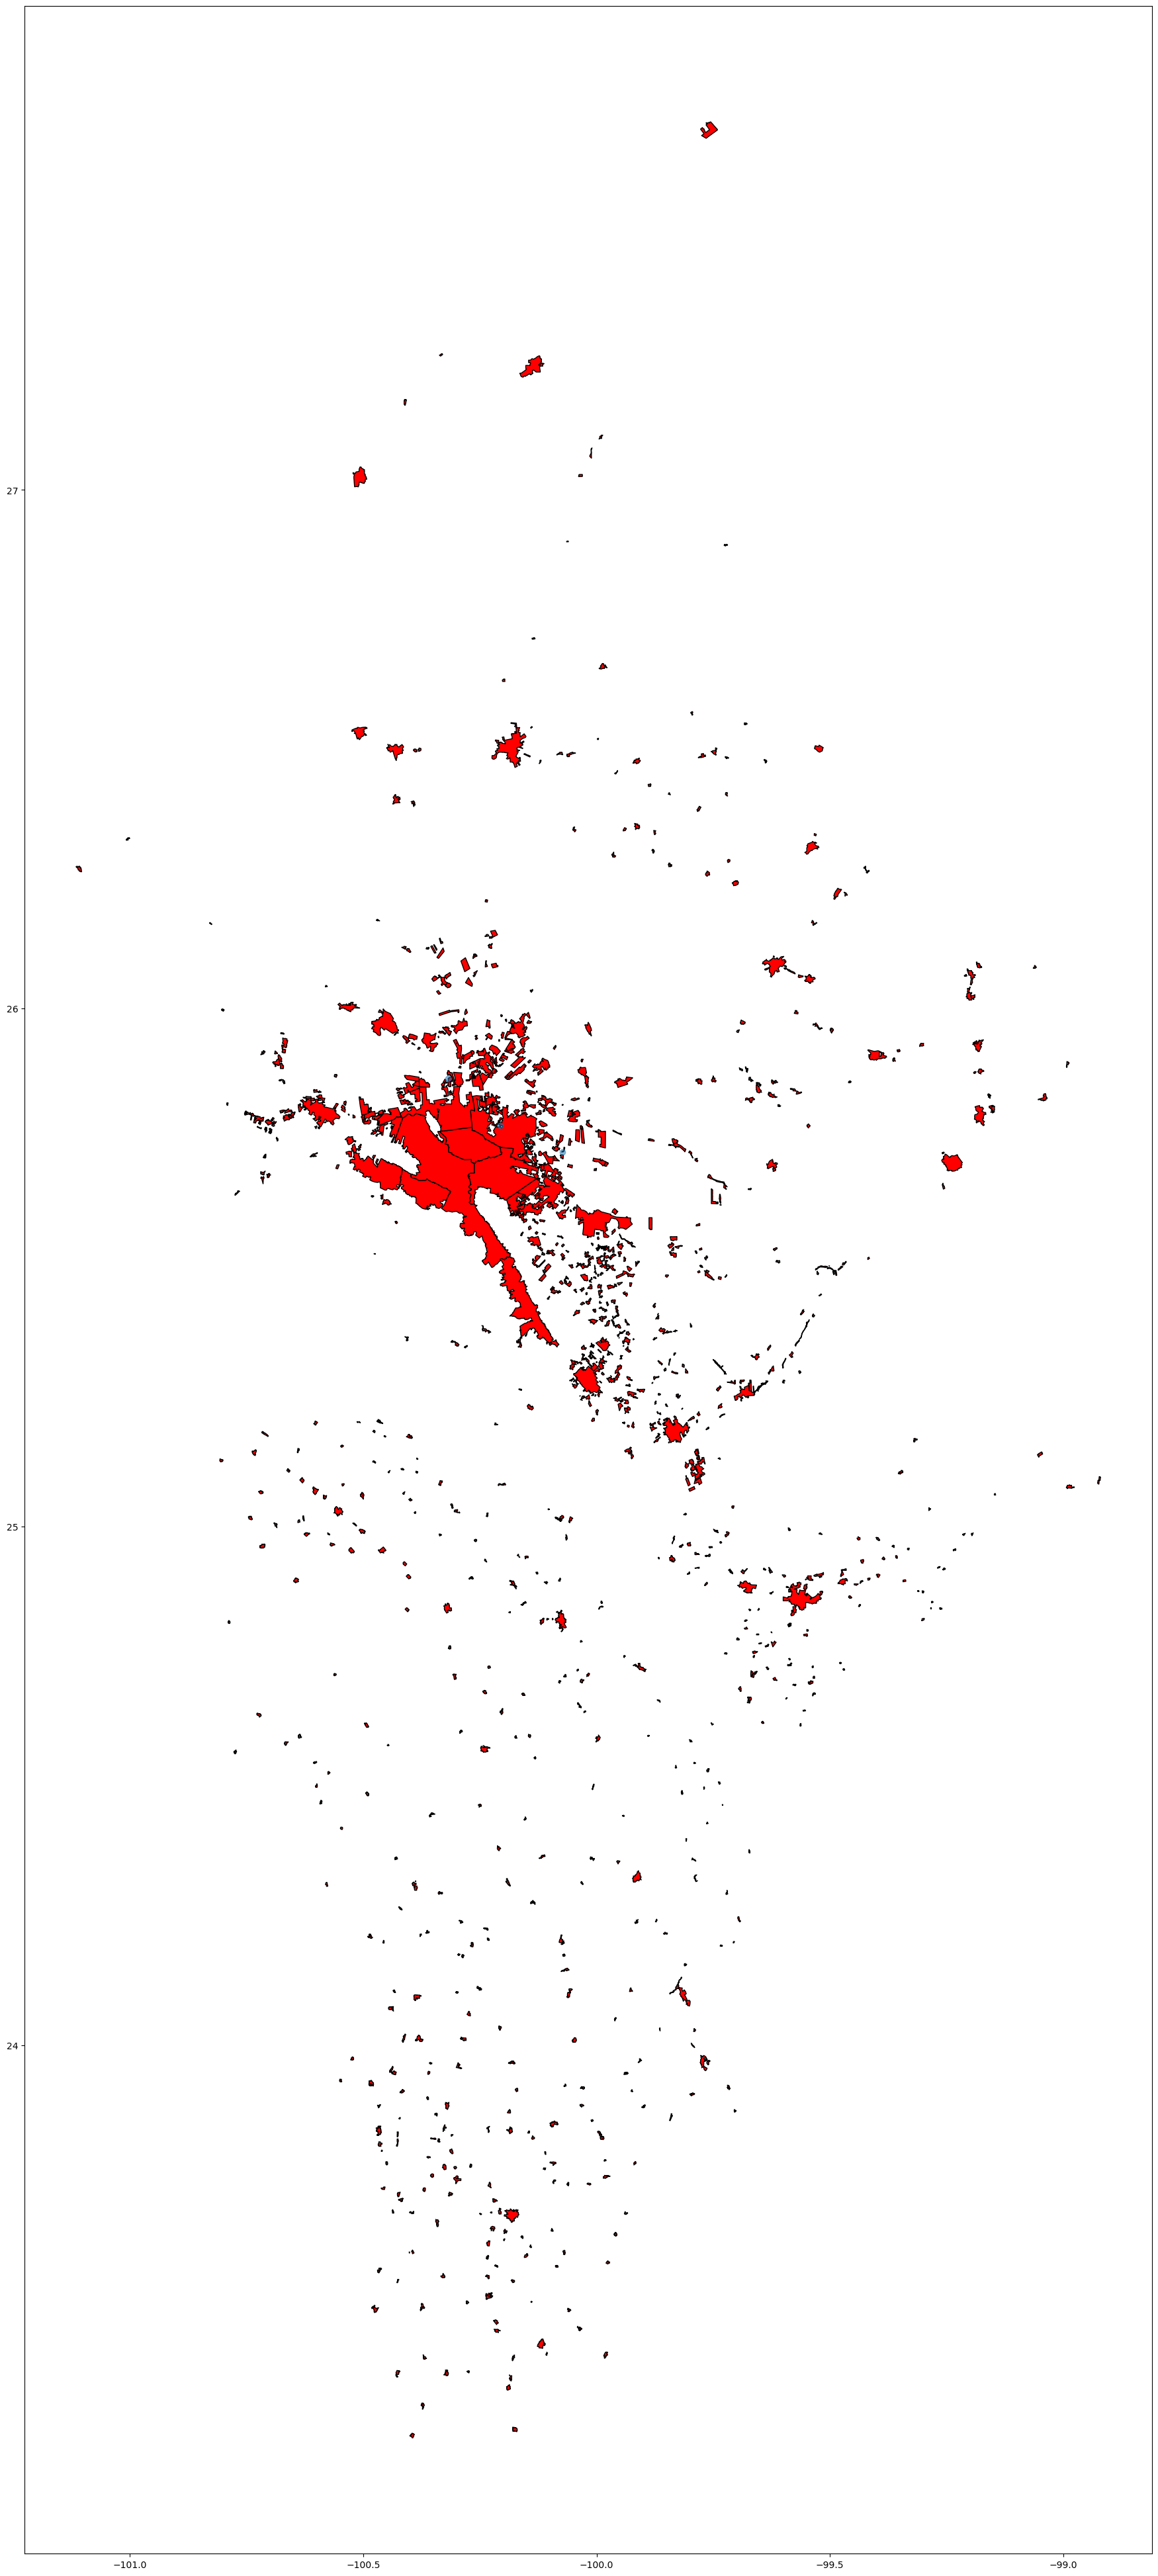

In [297]:
fig,ax = plt.subplots(figsize=(50,50))
mg_loc.to_crs(crs).plot(ax=ax, color='red', edgecolor='k')
conf_p.plot(ax=ax, alpha=0.5)

In [259]:
conflict_p = mun_sjoin[mun_sjoin['MUN'] != mun_sjoin['NOMGEO']]

In [260]:
conflict_p

,NunHabitante,Num_Viaje,Latitud,Longitud,MUN,ColDom,CalleDom,NExtDom,NIntDom,CPDom,geometry,index_right,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO
ID-HOGAR,,,,,,,,,,,,,,,,
62502-14,3,1,25.695075,-100.11744,Juárez,Anzures,París,228,None,67258.0,POINT (-100.11744 25.69507),12,19026,19,026,Guadalupe
62502-16,3,2,25.694968,-100.11747,Juárez,Anzures,París,232,None,67258.0,POINT (-100.11747 25.69497),12,19026,19,026,Guadalupe
62502-4,5,1,25.695268,-100.11742,Juárez,Anzures,París,206,None,67258.0,POINT (-100.11742 25.69527),12,19026,19,026,Guadalupe


In [37]:
od_df['H-P-V']

0         23853a-20/2-2
1         23853a-20/4-2
2         23853a-20/4-1
3         23853a-20/3-2
4         23853a-20/3-1
              ...      
90704      21759-24/2-1
90705       22902-8/3-2
90706       35413-6/1-1
90707      53968A-6/3-2
90708    11081-A-18/4-1
Name: H-P-V, Length: 90709, dtype: object

In [36]:
od_df['ID-HOGAR'].str.split('/', expand=True)

,0,1
0,23853a-20,None
1,23853a-20,None
2,23853a-20,None
3,23853a-20,None
4,23853a-20,None
...,...,...
90704,21759-24,None
90705,22902-8,None
90706,35413-6,None
90707,53968A-6,None


In [10]:
od_df['H-P'].value_counts(dropna=False)

41035-4/3       12
61415-3/2       11
43361-30/2      11
45175-5/1       11
43912-20/4      11
                ..
53546-4/2        1
55258-6/3        1
53687-6/1        1
53692-8/3        1
11081-A-18/4     1
Name: H-P, Length: 41554, dtype: int64

In [11]:
od_df['H-P-V'].value_counts(dropna=False)

23853a-20/2-2     1
14311-15/1-2      1
14221-10/3-2      1
14221-6/3-2       1
14221-6/3-1       1
                 ..
54323-2/2-2       1
54324-10/2-2      1
54324-10/1-1      1
54324-10/1-2      1
11081-A-18/4-1    1
Name: H-P-V, Length: 90709, dtype: int64

In [9]:
len(od_df)

90709

In [7]:
od_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90709 entries, 0 to 90708
Data columns (total 204 columns):
 #    Column                Dtype  
---   ------                -----  
 0    ID-HOGAR              object 
 1    H-P                   object 
 2    H-P-V                 object 
 3    Latitud               float64
 4    Longitud              float64
 5    FechaHoraEnc          object 
 6    NumVisita             object 
 7    TipoEnc               object 
 8    RealizoEnc            object 
 9    Encuestador           object 
 10   Supervisor            object 
 11   Cod_MunDomicilio      object 
 12   ColDom                object 
 13   CalleDom              object 
 14   NExtDom               object 
 15   NIntDom               object 
 16   RefDom                object 
 17   CPDom                 float64
 18   Punto_zona            int64  
 19   Cod_EdoDomicilio      object 
 20   LineaTelef            object 
 21   VHAuto                float64
 22   VHMoto              